# Train ALMA model

In [10]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras import backend as K
from sklearn.metrics import confusion_matrix
from PIL import Image
import pandas as pd
import time
import json
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import seaborn as sns 

In [3]:
#https://appliedmachinelearning.blog/2018/11/28/demonstration-of-facial-emotion-recognition-on-real-time-video-using-cnn-python-keras/

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [9]:
data = pd.read_pickle("./both_toTrain.pkl")

In [10]:
data.head() # columna de 'arrays' + columna de 'gt'

,emotion,path,array,angry,disgust,fear,happy,sadness,surprise,gt
0,sadness,fer2013/train/sadness/S071_002_00000020.png,"[[84, 85, 84, 85, 86, 87, 84, 82, 33, 25, 28, ...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"
1,sadness,fer2013/train/sadness/S130_009_00000019.png,"[[58, 34, 29, 12, 0, 0, 0, 0, 1, 0, 0, 1, 25, ...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"
2,sadness,fer2013/train/sadness/S125_001_00000012.png,"[[157, 129, 46, 45, 42, 43, 36, 32, 24, 29, 24...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"
3,sadness,fer2013/train/sadness/S071_002_00000018.png,"[[85, 85, 85, 86, 84, 83, 84, 79, 40, 24, 27, ...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"
4,sadness,fer2013/train/sadness/S106_002_00000015.png,"[[76, 75, 76, 81, 35, 34, 33, 35, 45, 39, 29, ...",0,0,0,0,1,0,"[0, 0, 0, 0, 1, 0]"


In [43]:
data['array'][0].shape

(48, 48)

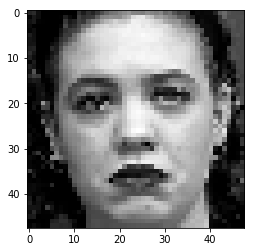

In [11]:
plt.imshow(data['array'][5], cmap="gray")

In [12]:
img_rows, img_cols, img_channels = 48, 48, 1

In [9]:
#data['array'] = data['array'].apply(lambda x: np.array([[[c] for c in i] for i in x]))

In [13]:
X = np.stack(data['array'])
X = X / 255.0 

In [14]:
y= np.stack(data['gt'])

In [15]:
y.shape

(24670, 6)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
input_shape=(img_rows, img_cols, img_channels)
num_classes=6

In [19]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19736, 48, 48) (4934, 48, 48) (19736, 6) (4934, 6)


### For the shape to be what the model needs 

In [20]:

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


In [18]:
#https://keras.io/getting-started/sequential-model-guide/

## NN convolutional 

In [ ]:
'''
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
'''

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(48, 48 ,1), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
adam = Adam(decay=decay)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,verbose=1, batch_size=50)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
'''
filepath='Checkpoint_{epoch:02d}_{val_accuracy:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
'''

In [20]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Accuracy: 67.07%
Test loss: 1.4079046540285443
Test accuracy: 0.6706526279449463


In [ ]:
'''
batch_size = 20
epochs = 25

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
'''

In [ ]:
'''
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
'''

## Save the model

In [21]:
moment=time.localtime()
name='Model_{}_{}-{}-{}.h5'.format(model.history.history["val_accuracy"][-1],moment[2],moment[3],moment[4])
model.save(name)

In [22]:
import json

model_json = model.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(name)

## Prediction <!>

In [59]:
class_names = ('Angry', 'Disgust','Fear','Happy','Sad','Surprise')

[2 4 2 ... 4 4 4]
[2 3 4 ... 4 2 4]


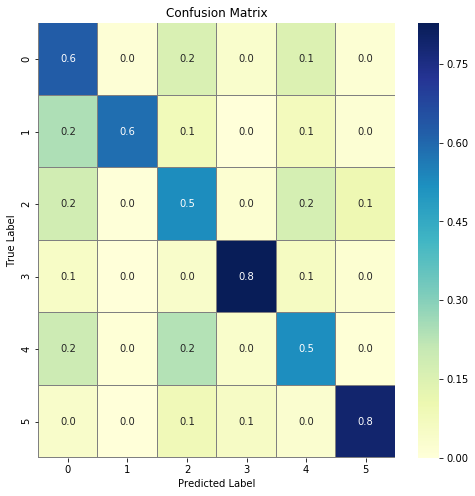

In [23]:
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Load model


In [6]:
with open('./models/Model_0.6706526279449463_16-8-18.h5.json','r') as f:
    model_json = json.load(f)
model = model_from_json(model_json)
model.load_weights('./models/Model_0.6706526279449463_16-8-18.h5')

### predict with test 

[8.8329433e-04 1.7898816e-05 2.7431769e-04 9.5660359e-01 5.7826075e-04
 4.1642629e-02]
Probs -> angry:0.00088 disgust:0.00002 fear:0.00027 happy:0.95660 sadness:0.00058 surprise:0.04164
(1, 48, 48, 1)


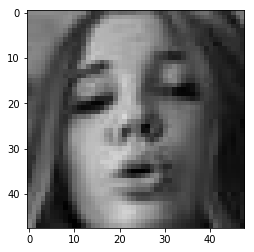

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = X_test[150]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
print("Probs -> angry:{0:.5f} disgust:{1:.5f} fear:{2:.5f} happy:{3:.5f} sadness:{4:.5f} surprise:{5:.5f}".format(pred[0],pred[1],pred[2],pred[3],pred[4],pred[5]))
print(np.expand_dims(img,axis=0).shape)
plt.imshow(Image.fromarray(img.squeeze()*255))

### predict with outsider 

In [7]:
def transfImag(path):
    print ('transforming image from {}'.format(path))

    input_img=cv2.imread(path)
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(input_img, 1.25, 6)
    x,y,w,h = faces[0]
    img_data= input_img[y:y+h,x:x+w]
    img_data=cv2.resize(img_data,(48,48))
    
    img_data = np.stack(img_data)
    img_data = img_data / 255.0
    
    return img_data

In [8]:
transfImag('real_pics/1.jpg')

transforming image from real_pics/1.jpg


array([[0.92156863, 0.92156863, 0.92156863, ..., 0.92156863, 0.92156863,
        0.92156863],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.92156863, 0.92156863,
        0.92156863],
       [0.92156863, 0.92156863, 0.92156863, ..., 0.92156863, 0.92156863,
        0.92156863],
       ...,
       [0.69411765, 0.73333333, 0.70980392, ..., 0.85882353, 0.88235294,
        0.90980392],
       [0.67843137, 0.6745098 , 0.69411765, ..., 0.90196078, 0.91764706,
        0.92156863],
       [0.70196078, 0.7254902 , 0.71372549, ..., 0.58823529, 0.89019608,
        0.90980392]])

-----------------------------------------------------------------------------------------------------------------

transforming image from real_pics/6.jpeg
(1, 48, 48, 1)
Probs -> angry:0.00040 disgust:0.00000 fear:0.00040 happy:0.96481 sadness:0.03438 surprise:0.00001


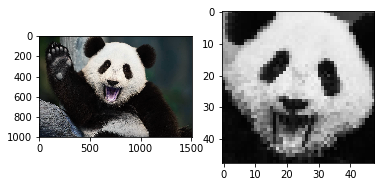

In [13]:
PIC = transfImag('real_pics/6.jpeg') # transform pic
input_img=cv2.imread('real_pics/6.jpeg') # get the array of the original pic

plt.subplot(121)
plt.imshow(input_img) # original pic
plt.subplot(122)
plt.imshow(Image.fromarray(PIC.squeeze()*255)) # transformed pic

PIC = np.expand_dims(PIC,axis=0).reshape(np.expand_dims(PIC,axis=0).shape[0], 48, 48, 1)
print(PIC.shape)
pred2 = model.predict(PIC)[0]
print("Probs -> angry:{0:.5f} disgust:{1:.5f} fear:{2:.5f} happy:{3:.5f} sadness:{4:.5f} surprise:{5:.5f}".format(pred2[0],pred2[1],pred2[2],pred2[3],pred2[4],pred2[5]))

In [41]:
# Hacer un try except por si no recone la cara en la imagen

In [15]:
print(pred2)

[3.97283904e-04 2.49067629e-08 3.96504940e-04 9.64810967e-01
 3.43805104e-02 1.47549335e-05]


In [16]:
pred2[0]

0.0003972839